# CNN Transfer Learning on Cats-Dogs Classification

### VGG16 trained on ImageNet data is used as pre-trained model from which to extract features.  Features are then saved, and passed through neural network with ReLu hidden layer to classify cats vs. dogs.

#### Adapted from fchollet/classifier_from_little_data_script_2.py (https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069) and blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K
from keras import applications
import numpy as np

In [3]:
import tensorflow as tf
print (tf.__version__)
print (keras.__version__)

1.7.0
2.2.2


In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0" 

### Set dimensions, number, and location of images

In [5]:
# Image dimensions
img_width, img_height = 150, 150

# Location of images
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
print (input_shape)

# Number of images
nb_train_samples = 2000
nb_validation_samples = 800

# Batch size
batch_size = 16

(150, 150, 3)


### Method to extract features from pre-trained network and save features

In [6]:
def save_features():
    
    # Scale pixel values in image
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Load the VGG16 network's imagenet weights, not including the last fully connected layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    # Generator that will read pictures found in subfolders of training data directory,
    # and indefinitely generate batches of image data (scaled)
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,        # Generator will only yield batches of data, no labels
        shuffle=False)          # Data will be presented in order, i.e., 1000 cat images, then 1000 dog images
    
    # The predict_generator method returns the output of the model, given input provided by a generator
    # that yields batches of numpy data
    features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    # Save model outputs (i.e., features) from model as numpy array
    np.save('features_train.npy', features_train) 

    # Generator to generator validation input for model
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Get model output for validation data
    features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    # Save model outputs (i.e., features) for validation data
    np.save('features_validation.npy', features_validation) 
    
    # Print out model architecture
    model.summary()

### Call method to extract and save features from pre-trained network

In [7]:
save_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
___________________________________________________________

### Load saved features

In [8]:
# Load saved features for train data
train_data = np.load('features_train.npy')
    
# Create labels for train data.  Images were generated in order, so creating labels is easy.
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2)) 

# Load saved features for validation data
validation_data = np.load('features_validation.npy') 
    
# Create labels for validation data
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2)) 
    
print (train_labels.shape, validation_labels.shape)

(2000,) (800,)


### Create top model

In [9]:
# Create fully connected layer on top of model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))  # Convert 3D feature maps to 1D feature vectors
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Create model
top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(top_model)
top_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Train top model

In [10]:
# Set up model
epochs = 50

# Train model, keeping track of history
from keras.callbacks import History
hist = top_model.fit(train_data, train_labels,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s 494us/step - loss: 0.7990 - acc: 0.7510 - val_loss: 0.2857 - val_acc: 0.8825
Epoch 2/50
2000/2000 [==============================] - 0s 220us/step - loss: 0.3473 - acc: 0.8540 - val_loss: 0.4275 - val_acc: 0.8287
Epoch 3/50
2000/2000 [==============================] - 0s 222us/step - loss: 0.2847 - acc: 0.8845 - val_loss: 0.2623 - val_acc: 0.9075
Epoch 4/50
2000/2000 [==============================] - 0s 222us/step - loss: 0.2660 - acc: 0.8960 - val_loss: 0.2492 - val_acc: 0.9000
Epoch 5/50
2000/2000 [==============================] - 0s 219us/step - loss: 0.2419 - acc: 0.9135 - val_loss: 0.2675 - val_acc: 0.9075
Epoch 6/50
2000/2000 [==============================] - 0s 219us/step - loss: 0.2047 - acc: 0.9265 - val_loss: 0.2668 - val_acc: 0.9100
Epoch 7/50
2000/2000 [==============================] - 0s 220us/step - loss: 0.1908 - acc: 0.9335 - val_loss: 0.3093 - val_acc: 0.9000
E

### Save model and weights

In [11]:
# Save model & weights to HDF5 file
top_model_file = 'features_model' 
top_model.save(top_model_file + '.h5')

# Save model to JSON file & weights to HDF5 file
top_model_json = top_model.to_json()
with open(top_model_file + '.json','w') as json_file:
    json_file.write(top_model_json)
top_model.save_weights(top_model_file+'-wts.h5')

# Results on validation set
print (top_model.metrics_names)
results = top_model.evaluate (validation_data, validation_labels)
print (results)

['loss', 'acc']
800/800 [==============================] - 0s 76us/step
[1.0258445458766072, 0.9]


### Load model again and test

In [12]:
top_model2 = keras.models.load_model(top_model_file+'.h5')
print (validation_labels.shape)

print (top_model2.metrics_names)
results = top_model2.evaluate(validation_data, validation_labels)
print (results)

(800,)
['loss', 'acc']
800/800 [==============================] - 0s 121us/step
[1.0258445458766072, 0.9]


### Print training history

In [13]:
print (hist.history)

{'loss': [0.7989897830486298, 0.3472850636541843, 0.28470033037662507, 0.2659973061680794, 0.241860317427665, 0.20471238232403993, 0.1907775649537798, 0.1586583878239617, 0.13478900037519634, 0.11906744509004057, 0.11381199467601255, 0.08906235697539523, 0.10302183923277335, 0.08076736309871194, 0.08368151758090243, 0.07143723758666601, 0.060591624210617735, 0.0565113622963363, 0.05733685208619135, 0.03856882109989783, 0.036351935350099666, 0.04756382276046133, 0.03265383930305052, 0.0209799905805653, 0.04020391717047255, 0.04903297051042023, 0.024042593909681272, 0.03204362702720016, 0.037245497337285084, 0.024125897369958297, 0.01935493189380418, 0.025071589789112125, 0.014850615837679413, 0.01138185172230817, 0.03170836195569797, 0.015377778306373784, 0.025857034962036153, 0.018385551675915053, 0.01738293807710289, 0.017098450002244876, 0.017819965100790397, 0.006169357080500049, 0.009540540902651912, 0.013443469863565781, 0.012087495277006553, 0.01516633341773462, 0.016598670775290

### Plot accuracies

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


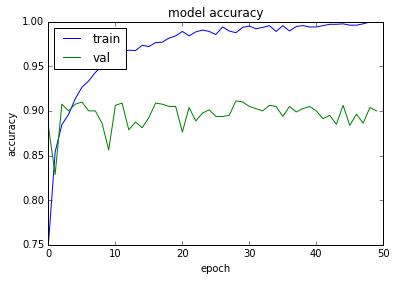

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

result = hist.history

# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()